In [1]:
## GTI770 - TP1

In [1]:
%matplotlib inline   
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import graphviz
from sklearn import tree
from sklearn.metrics import accuracy_score

In [2]:
# Get some images
fid = open('GTI770_label_data_set.csv', 'r') 
next(fid) # skip les headers (la premiere ligne)

classDict = {}
imgNb = 1200
X = np.zeros((imgNb, 3, 424, 424), dtype=int)
Y = np.zeros((imgNb, 2), dtype=object)

count = 0
for line in fid:
    element = line.rstrip('\n').split(',')
    
    if element[1] not in classDict:
        classDict[element[1]] = 0     
    elif element[1] in classDict and classDict[element[1]] < imgNb/2:
        classDict[element[1]] += 1;
    else:
        continue
    
    imagePath = 'images/' + element[0] + '.jpg'
    if not os.path.exists(imagePath):
        classDict[element[1]] -= 1    # S'assure d'avoir des images qui existe
        continue
        
    img = cv2.imread(imagePath).reshape(3,424,424)
    img = img[:, :, ::-1]
    
    X[count] = img
    Y[count] = [count, element[1]]
    
    count += 1
    if count >= imgNb:
        break

fid.close() 

In [3]:
def GenerateRandomNumbersList(ArangeLength, GeneratedSetLength):
    a = np.arange(ArangeLength)
    np.random.shuffle(a)
    randomSet = a[:GeneratedSetLength]
    return randomSet

rand1 = GenerateRandomNumbersList(imgNb/2, 10)
rand2 = GenerateRandomNumbersList(imgNb/2, 10)

YSorted = Y[Y[:,1].argsort()]
listSmooth = YSorted[:len(YSorted)//2]
listSpiral = YSorted[len(YSorted)//2:]

In [4]:
train_prop = 0.7
trainNb = int((imgNb * train_prop)/2)

# Étant donné que validation n'est pas nécessaire pour ce laboratoire,
# il contient les mêmes données que test
#test_prop = (1 - train_prop) / 2
#val_prop = (1 - train_prop) / 2
test_prop = (1 - train_prop) 
val_prop = (1 - train_prop) 

valNb = int((imgNb * val_prop) / 2)
testNb = int((imgNb * test_prop) / 2)


Y_train = np.concatenate((listSmooth[:trainNb], listSpiral[:trainNb]), axis=0)
Y_val = np.concatenate((listSmooth[trainNb:trainNb+valNb], listSpiral[trainNb:trainNb+valNb]), axis=0)
Y_test = np.concatenate((listSmooth[-testNb:], listSpiral[-testNb:]), axis=0)

def GenerateXFromY(listY):
    listX = np.zeros((len(listY), 3, 424, 424), dtype=int)
    for i in range(len(listY)):
        imageIndex = listY[i]
        listX[i] = X[imageIndex[0]]
    return listX

X_train = GenerateXFromY(Y_train)
X_val = GenerateXFromY(Y_val)
X_test = GenerateXFromY(Y_test)

#----------------------
#For debug :
# print(len(Y_train))
# print(Y_train)
# print(len(Y_test))
# print(Y_test)
# print(len(X_train))
# print(len(X_test))
#----------------------

In [5]:
def crop(img,cropx,cropy):
    x,y,rgb = img.shape #Prend les valeurs de l'image
    startx = x//2-(cropx//2) #Trouve la nouvelle coordonnée startx
    starty = y//2-(cropy//2) #Trouve la nouvelle coordonnée starty
    return img[startx:startx+cropx,starty:starty+cropy] #Réajuste l'image selon les nouvelle coordonnée et la longueur du crop

X_train_crop = np.zeros((len(X_train), 3, 50, 50), dtype=np.uint8)
X_val_crop = np.zeros((len(X_val), 3, 50, 50), dtype=np.uint8)
X_test_crop = np.zeros((len(X_test), 3, 50, 50), dtype=np.uint8)
for i in range(0, len(X_train)):
    X_train_crop[i] = crop(X_train[i].reshape(424, 424, 3),50,50).reshape(3, 50, 50)
    
for i in range(0, len(X_val)):
    X_val_crop[i] = crop(X_val[i].reshape(424, 424, 3),50,50).reshape(3, 50, 50)
    
for i in range(0, len(X_test)):
    X_test_crop[i] = crop(X_test[i].reshape(424, 424, 3),50,50).reshape(3, 50, 50)
    
#-----------------------
#For Debug :
# print(len(X_train_crop))
# print(len(X_train_crop[0][0]))
# print(len(X_train_crop[0][0][0]))
#-----------------------    

In [6]:
def RgbToGray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114]) #Transforme l'image couleur en grayscale

def ToBinaryImage(array):
    binary = np.zeros((len(array), 50, 50), dtype=float)
    for i in range(0, len(array)):
        grayscale = RgbToGray(array[i].reshape(50,50,3))
        thresh_img = np.where(grayscale>128, 255, 0)
        binary[i] = thresh_img
    return binary

X_train_binary = ToBinaryImage(X_train_crop)
X_val_binary = ToBinaryImage(X_val_crop)
X_test_binary = ToBinaryImage(X_test_crop)

#-------------------------------------------
#For debug :
#plt.imshow(X_train_binary[45], cmap=plt.cm.gray)
#plt.imshow(X_train_crop[52].reshape(50,50,3))
#-------------------------------------------

In [7]:
#separate color channels

X_train_crop_red = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_train_crop_green = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_train_crop_blue_high = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_train_crop_blue_mid = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_train_crop_yellow = np.zeros((len(X_train_crop),50, 50), dtype=int)
X_val_crop_blue_mid = np.zeros((len(X_val_crop),50, 50), dtype=int)
X_test_crop_blue_mid = np.zeros((len(X_test_crop),50, 50), dtype=int)


def ShowColorComparison(imgIndex):
    img = X_train[imgIndex].reshape(424,424,3)
    img_cropped = np.zeros((50, 50, 3), dtype=int)
    img_cropped =  X_train_crop[imgIndex].reshape(50,50,3)
    f, axarr = plt.subplots(1, 7, figsize=(20,20))
    axarr[0].imshow(img)
    axarr[1].imshow(img_cropped)
    
    img_red = np.zeros((50, 50, 1), dtype=int)
    img_green = np.zeros((50, 50, 1), dtype=int)
    img_blue_high = np.zeros((50, 50, 1), dtype=int)
    img_blue_mid = np.zeros((50, 50, 1), dtype=int)
    img_red, img_green, img_blue_high, img_blue_mid = SplitColors(img_cropped)
    
    axarr[2].imshow(img_red, cmap=plt.cm.Reds)
    axarr[3].imshow(img_green, cmap=plt.cm.Greens)
    axarr[4].imshow(img_blue, cmap=plt.cm.Blues)
    axarr[5].imshow(X_train_binary[imgIndex], cmap=plt.cm.gray)
    axarr[6].imshow(img_blue2, cmap=plt.cm.gray)
    plt.show()
    
def SplitRgb(rgb, th_red, th_green, th_blue):
    red = rgb[:, :, 0] > th_red
    green = rgb[:, :, 1] > th_green
    blue = rgb[:, :, 2] > th_blue
    return red, green, blue

def AvgYellow(rgb, th_yel):
    yellow = rgb[:, :, 0]+rgb[:, :, 1]/2 > th_yel
    return yellow

def ShowAll():
    for i in range(0, len(X_train)):
        print("%d- %s" %(i, Y_train[i][1]))
        ShowColorComparison(i)
        
def SplitColors(img_cropped):
    img_red = np.zeros((50, 50, 1), dtype=int)
    img_green = np.zeros((50, 50, 1), dtype=int)
    img_blue_high = np.zeros((50, 50, 1), dtype=int)
    img_blue_mid = np.zeros((50, 50, 1), dtype=int)
    img_yellow = np.zeros((50, 50, 1), dtype=int)
    img_red, img_green, img_blue_high = SplitRgb(img_cropped, 200, 160, 160)
    img_blue_mid = np.where(img_cropped[:,:,2]>90, 255, 0)
    img_yellow = AvgYellow(img_cropped, 160)
    return img_red, img_green, img_blue_high, img_blue_mid, img_yellow

def SplitAllImagesColors():
    img_red = np.zeros((50, 50, 1), dtype=int)
    img_green = np.zeros((50, 50, 1), dtype=int)
    img_blue_high = np.zeros((50, 50, 1), dtype=int)
    img_blue_mid = np.zeros((50, 50, 1), dtype=int)
    img_yellow = np.zeros((50, 50, 1), dtype=int)
    
    for i in range(0, len(X_train_crop)):
        img_red, img_green, img_blue_high, img_blue_mid, img_yellow = SplitColors(X_train_crop[i].reshape(50,50,3))
        X_train_crop_red[i] = img_red
        X_train_crop_green[i] = img_green
        X_train_crop_blue_high[i] = img_blue_high
        X_train_crop_blue_mid[i] = img_blue_mid
        X_train_crop_yellow[i] = img_yellow
    for i in range(0, len(X_val_crop)):
        img_red, img_green, img_blue_high, img_blue_mid, img_yellow = SplitColors(X_val_crop[i].reshape(50,50,3))
        X_val_crop_blue_mid[i] = img_blue_mid
    for i in range(0, len(X_test_crop)):
        img_red, img_green, img_blue_high, img_blue_mid, img_yellow = SplitColors(X_test_crop[i].reshape(50,50,3))
        X_test_crop_blue_mid[i] = img_blue_mid

SplitAllImagesColors()

#-------------------------------------------
#For debug :
# ShowAll()

#print(len(X_train_crop_green))
#print(len(X_train_crop_blue_high))
#print(len(X_train_crop_blue_mid))
#-------------------------------------------

In [8]:
#Extraction de primitive
def TracePlot(array, titre, titre_x, titre_y):        
    length_smooth = 0
    length_spiral = 0

    for element in Y_train :
        if element[1] == "smooth" :
            length_smooth += 1
        elif element[1] == "spiral" :
            length_spiral += 1
            
    X_coord_smooth = np.zeros(length_smooth, dtype=float)
    Y_coord_smooth = np.zeros(length_smooth, dtype=float)
    X_coord_spiral= np.zeros(length_spiral, dtype=float)
    Y_coord_spiral = np.zeros(length_spiral, dtype=float)

    count_smooth = 0
    count_spiral = 0
    for i in range(0, len(X_train)):
        if Y_train[i][1] == "smooth" :
            X_coord_smooth[count_smooth] = array[i][0]
            Y_coord_smooth[count_smooth] = array[i][1]
            count_smooth += 1
        elif Y_train[i][1] == "spiral" :
            X_coord_spiral[count_spiral] = array[i][0]
            Y_coord_spiral[count_spiral] = array[i][1]
            count_spiral += 1
    
    plt.plot(X_coord_smooth, Y_coord_smooth, 'ro')
    plt.plot(X_coord_spiral, Y_coord_spiral, 'g*')
    plt.xlabel(titre_x)
    plt.ylabel(titre_y)
    plt.title(titre)
    plt.grid(True)
    plt.show()
    
def ExtractNumberOfBlackAndWhitePixels(img_array):
    X_train_plot = np.zeros((len(img_array), 2), dtype=int)
    for i in range(0, len(img_array)): 
        X_train_plot[i][0] = np.sum(img_array[i] == 1) or np.sum(img_array[i] == 255) #Number of white pixels
        X_train_plot[i][1] = np.sum(img_array[i] == 0) #Number of black pixels
    return X_train_plot

#--------------------------------------------------------------------
# For debug :
# X_train_plot = np.zeros((len(X_train), 2), dtype=int)
# for i in range(0, len(X_train)):
#     X_train_plot[i][0] = np.sum(X_train_crop_green[i] == 1) #Number of white pixels
#     X_train_plot[i][1] = np.sum(X_train_crop_green[i] == 0) #Number of black pixels
# print(X_train_plot)
# print(X_train_crop_green[0][0][0])
#TracePlot(ExtractNumberOfBlackAndWhitePixels(X_train_crop_green), 'Nombre de pixels blanches en fonction du nombre de pixels noires dans les images binaires avec seulement le channel vert', 'Nombre de pixels blancs', 'Nombre de pixels noirs')
#TracePlot(ExtractNumberOfBlackAndWhitePixels(X_train_binary), 'Nombre de pixels blanches en fonction du nombre de pixels noires dans les images binaire grayscale', 'Nombre de pixels blancs', 'Nombre de pixels noirs')
#---------------------------------------------------------------------

In [9]:
#Extraction de primitives

def ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale(arrayBinary, arrayBlue):
    X_train_plot = np.zeros((len(arrayBinary), 2), dtype=float)
    for i in range(0, len(arrayBinary)): 
        X_train_plot[i][0] = np.sum(arrayBinary[i] == 255)
        X_train_plot[i][1] = np.sum(arrayBlue[i] == 255) #or np.sum(X_train_crop_blue_mid[i] == 255)
    return X_train_plot

def ExtractRatioOfBluePixelsVersusWhitePixelsInGrayscale(arrayBinary, arrayBlue, arrayY):
    X_train_plot = np.zeros((len(arrayBinary), 2), dtype=float)
    for i in range(0, len(arrayBinary)): 
        if arrayY[i][1] == "smooth" :
            X_train_plot[i][0] = 0
        elif arrayY[i][1] == "spiral" :
            X_train_plot[i][0] = 1
        if np.sum(arrayBinary[i] == 255) == 0 :
            X_train_plot[i][1] = 0
        else :
            X_train_plot[i][1] = np.sum(arrayBlue[i] == 255) / np.sum(arrayBinary[i] == 255)
    return X_train_plot
        
def NumberOfRatioHigherThan(ratio, array):
    totalSmooth = 0
    totalSpiral = 0
    for i in range(0, len(array)):
        if Y_train[i][1] == "smooth" :
            if array[i][1] > ratio :
                totalSmooth += 1
        elif Y_train[i][1] == "spiral" :
            if  array[i][1] > ratio :
                totalSpiral += 1
    return totalSmooth, totalSpiral

def Entropie(p1, p2, t):
    entropie = -(p1/t*np.log2(p1/t))-(p2/t*np.log2(p2/t))
    return entropie

def Gain(p1, p2, t, e1, e2, e3):
    gain = e3 - p1/t*e1 - p2/t*e2
    return gain

#---------------------------------------------------------
#For debug :
#print(Entropie(29, 35, 64))
#print(Entropie(21, 5, 26))
#print(Entropie(8, 30, 38))
#print("Nbr smooth high = %d, Nbr smooth lesser = %d \nNbr spiral = %d, Nbr spiral lesser = %d" %(nbSmooth, nbSmoothLesser, nbSpiral, nbSpiralLesser))
#print(Gain(21, 5, 26, Entropie(21, 5, 26), Entropie(8, 30, 38), Entropie(29, 35, 64)))
#TracePlot(ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
#TracePlot(ExtractRatioOfBluePixelsVersusWhitePixelsInGrayscale(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
#---------------------------------------------------------

In [10]:
#Extraction de primitives (Selon teintes de jaune... non concluant)
def ExtractNbOfBluePixelsVersusAverageYellow():
    X_train_plot = np.zeros((len(X_train), 2), dtype=float)
    for i in range(0, len(X_train)): 
        X_train_plot[i][0] = np.sum(X_train_crop_yellow[i] == 1)
        X_train_plot[i][1] = np.sum(X_train_crop_blue_mid[i] == 255) #or np.sum(X_train_crop_blue_mid[i] == 255)
    return X_train_plot

def ExtractRatioBlueVsYellow():
    X_train_plot = np.zeros((len(X_train), 2), dtype=float)
    for i in range(0, len(X_train)): 
        if Y_train[i][1] == "smooth" :
            X_train_plot[i][0] = 0
        elif Y_train[i][1] == "spiral" :
            X_train_plot[i][0] = 1
        if np.sum(X_train_crop_yellow[i] == 1) == 0 :
            X_train_plot[i][1] = 0
        else :
            X_train_plot[i][1] = np.sum(X_train_crop_blue_mid[i] == 255) / np.sum(X_train_crop_yellow[i] == 1)
    return X_train_plot

def ExtractRatioYellowVsBlue():
    X_train_plot = np.zeros((len(X_train), 2), dtype=float)
    for i in range(0, len(X_train)): 
        if Y_train[i][1] == "smooth" :
            X_train_plot[i][0] = 0
        elif Y_train[i][1] == "spiral" :
            X_train_plot[i][0] = 1
        if np.sum(X_train_crop_blue_mid[i] == 255) == 0 :
            X_train_plot[i][1] = 0
        else :
            X_train_plot[i][1] = np.sum(X_train_crop_yellow[i] == 1) / np.sum(X_train_crop_blue_mid[i] == 255)
    return X_train_plot
#--------------------------------------------------------------------
# For debug :
#TracePlot(ExtractNbOfBluePixelsVersusAverageYellow(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
#TracePlot(ExtractRatioBlueVsYellow(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
#TracePlot(ExtractRatioYellowVsBlue(), "titre", "Nombre de pixels blanches de l'image binaire du grayscale", "Nombre de pixels blanches de l'image binaire du canal bleu")
#--------------------------------------------------------------------

In [11]:
#extraction de primitive (ratio longueur/largeur)
def GetStretchRatio(img, threshold):
    
    img = img[...,::-1]
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, grayscale = cv2.threshold(grayscale,threshold,255, cv2.THRESH_BINARY)
    binary, contours, hierarchy = cv2.findContours(grayscale, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    params = cv2.SimpleBlobDetector_Params()
    params.filterByColor = True
    params.blobColor = 255

    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(img)

    # Trouver le plus gros blob
    mx = (0,0,0)
    mx_area = 0
    ratio = 0.0
    for cont in contours:
        rect = cv2.minAreaRect(cont)
        tempbox = cv2.boxPoints(rect)
        p1 = tempbox[0] - tempbox[1]    # points
        p2 = tempbox[3] - tempbox[0]
        c1 = p1[1]  # coordonnées
        c2 = p2[0]
        area = c1 * c2
        if area > mx_area:
            mx = rect
            mx_area = area
            ratio = min(c1,c2) / max(c1,c2)
    # box = cv2.boxPoints(mx)
    # box = np.int0(box)

    # Pour debug/voir le minRect
    # cv2.drawContours(binary, [box], 0, (255, 0, 0))
    # cv2.imshow("contours", binary)
    # cv2.waitKey(0)

    return ratio

def ExtractRatio(threshold, arrayCrop , arrayY):
    X_train_plot = np.zeros((len(arrayCrop), 2), dtype=float)
    for i in range(0, len(arrayCrop)): 
        if arrayY[i][1] == "smooth" :
            X_train_plot[i][0] = 0
        elif arrayY[i][1] == "spiral" :
            X_train_plot[i][0] = 1    
        X_train_plot[i][1] = GetStretchRatio(arrayCrop[i].reshape(50,50,3), threshold)
    return X_train_plot

In [12]:
# Stats
def Mean(array):
    count_smooth = 0
    count_spiral = 0
    sum_smooth = 0
    sum_spiral = 0
    for i in range(0, len(array)): 
        if Y_train[i][1] == "smooth" :
            count_smooth += 1
            sum_smooth+= array[i][1]
        elif Y_train[i][1] == "spiral" :
            count_spiral += 1
            sum_spiral+= array[i][1]
    
    print("Mean Smooth: ", sum_smooth/count_smooth)
    print("Mean Spiral: ", sum_spiral/count_spiral)


def Median(array):
    count_smooth = 0
    count_spiral = 0
    med_smooth = 0
    med_spiral = 0
    med = np.round(len(Y_train)/4)
    for i in range(0, len(array)): 
        if Y_train[i][1] == "smooth" :
            count_smooth += 1
            if count_smooth == med:
                med_smooth = array[i][1]
        elif Y_train[i][1] == "spiral" :
            count_spiral += 1
            if count_spiral == med:
                med_smooth = array[i][1]
                
    print("Median Smooth: ", med_smooth)
    print("Median Spiral: ", med_spiral)

#----------------------------------------------
# For debug :
# ratio_arr = ExtractRatio(127)
# Mean(ratio_arr)
# Median(ratio_arr)
# TracePlot(ratio_arr, "Ratio", "", "Ratio")
#----------------------------------------------

In [13]:
# Export Data
# ['ratio longueur/largeur', 'pixels blanches grayscale', 'pixels bleu']

num_features = 3 
num_features += 1
ratioThreshold = 127

ratio_train = ExtractRatio(ratioThreshold, X_train_crop, Y_train) 
whitePixel_train = ExtractNumberOfBlackAndWhitePixels(X_train_binary)
bluePixel_train = ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale(X_train_binary, X_train_crop_blue_mid)

ratio_val = ExtractRatio(ratioThreshold, X_val_crop, Y_val) 
whitePixel_val = ExtractNumberOfBlackAndWhitePixels(X_val_binary)
bluePixel_val = ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale(X_val_binary, X_val_crop_blue_mid)

ratio_test = ExtractRatio(ratioThreshold, X_test_crop, Y_test) 
whitePixel_test = ExtractNumberOfBlackAndWhitePixels(X_test_binary)
bluePixel_test = ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale(X_test_binary, X_test_crop_blue_mid)

def ExportData(arrayY, ratio, whitePixel, bluePixel, name):
    feature_vector = np.zeros((len(arrayY), num_features), dtype=float)
    for i in range(0, len(arrayY)): 
        if arrayY[i][1] == "smooth" :
            feature_vector[i] = [ratio[i][1], whitePixel[i][0], bluePixel[i][1], 0]
        elif arrayY[i][1] == "spiral" :
            feature_vector[i] = [ratio[i][1], whitePixel[i][0], bluePixel[i][1], 1]
    
        print (feature_vector[i]) 

    np.savetxt("galaxy_%s.csv" %name, feature_vector, delimiter=",")

In [14]:
ExportData(Y_train, ratio_train, whitePixel_train, bluePixel_train, "train")
ExportData(Y_val, ratio_val, whitePixel_val, bluePixel_val, "val")
ExportData(Y_test, ratio_test, whitePixel_test, bluePixel_test, "test")

[  0.95804197 599.         608.           0.        ]
[9.5102036e-01 1.0670000e+03 7.1500000e+02 0.0000000e+00]
[ 1. 73.  0.  0.]
[9.7278899e-01 9.9200000e+02 7.4600000e+02 0.0000000e+00]
[  0.8888889 214.          0.          0.       ]
[  0.85000014 266.         117.           0.        ]
[  0.91666669 127.          28.           0.        ]
[  0.89795882 247.         152.           0.        ]
[  0.79166669 298.         177.           0.        ]
[8.63157988e-01 1.95400000e+03 1.05700000e+03 0.00000000e+00]
[1.000e+00 4.730e+02 2.493e+03 0.000e+00]
[  1. 148.  69.   0.]
[8.82736683e-01 1.48900000e+03 5.61000000e+02 0.00000000e+00]
[9.67741907e-01 1.20600000e+03 7.85000000e+02 0.00000000e+00]
[  0.75 302.     0.     0.  ]
[  0.90909094 205.          36.           0.        ]
[  0.90909094 191.          26.           0.        ]
[  0.95652175 749.         309.           0.        ]
[  0.86666667 230.          28.           0.        ]
[8.99999976e-01 1.07900000e+03 5.48000000e+02 0.00

[  0.85365856 430.         345.           0.        ]
[  0.83221471 795.         432.           0.        ]
[9.59183693e-01 2.18200000e+03 2.43100000e+03 0.00000000e+00]
[  0.88 720.   434.     0.  ]
[  0.7869823 538.        372.          0.       ]
[  0.875 171.      0.      0.   ]
[  0.96153843 821.         483.           0.        ]
[9.11764681e-01 1.28700000e+03 8.10000000e+02 0.00000000e+00]
[  0.9523809 728.        586.          0.       ]
[  0.80000001 254.           0.           0.        ]
[  0.96969742 157.         108.           0.        ]
[7.74193525e-01 8.70000000e+02 8.83000000e+02 0.00000000e+00]
[9.28571403e-01 1.59700000e+03 1.70900000e+03 0.00000000e+00]
[7.53846109e-01 1.30500000e+03 2.43700000e+03 0.00000000e+00]
[  0. 133.   0.   0.]
[  1. 302. 248.   0.]
[9.3617022e-01 1.7760000e+03 2.2200000e+03 0.0000000e+00]
[  0.94444442 757.         784.           0.        ]
[  0.84848487 593.         399.           0.        ]
[9.47368443e-01 1.86300000e+03 1.88600000e+03 

[7.74193525e-01 8.70000000e+02 8.83000000e+02 0.00000000e+00]
[9.28571403e-01 1.59700000e+03 1.70900000e+03 0.00000000e+00]
[7.53846109e-01 1.30500000e+03 2.43700000e+03 0.00000000e+00]
[  0. 133.   0.   0.]
[  1. 302. 248.   0.]
[9.3617022e-01 1.7760000e+03 2.2200000e+03 0.0000000e+00]
[  0.94444442 757.         784.           0.        ]
[  0.84848487 593.         399.           0.        ]
[9.47368443e-01 1.86300000e+03 1.88600000e+03 0.00000000e+00]
[9.70588207e-01 1.30200000e+03 1.22000000e+03 0.00000000e+00]
[9.375e-01 2.064e+03 2.254e+03 0.000e+00]
[  0.94736844 487.         219.           0.        ]
[  0.86666691 180.          33.           0.        ]
[7.5641036e-01 1.3420000e+03 1.2140000e+03 0.0000000e+00]
[  0.94736844 305.          55.           0.        ]
[8.66666675e-01 8.74000000e+02 1.31600000e+03 0.00000000e+00]
[5.60000002e-01 6.62000000e+02 1.16000000e+02 0.00000000e+00]
[  1. 215.  44.   0.]
[  0.87654316 421.         205.           0.        ]
[  0.8888889 128. 

In [66]:
# Import train Data

def ImportTrainData():
    num_features = 3
    
    data_train = np.loadtxt("galaxy_train.csv", delimiter=",")
    X_train_tree  = data_train[:,0:num_features]
    Y_train_tree  = data_train[:,num_features]
    
    data_val = np.loadtxt("galaxy_val.csv", delimiter=",")
    X_val_tree  = data_val[:,0:num_features]
    Y_val_tree  = data_val[:,num_features]
    
    data_test = np.loadtxt("galaxy_test.csv", delimiter=",")
    X_test_tree  = data_test[:,0:num_features]
    Y_test_tree  = data_test[:,num_features]
    
    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=6)
    model = model.fit(X_train_tree, Y_train_tree)
    prediction_train = model.predict(X_train_tree)
    prediction_val = model.predict(X_val_tree)
    prediction_test = model.predict(X_test_tree)
    return model, prediction_train, prediction_val, prediction_test, Y_train_tree, Y_val_tree, Y_test_tree

In [67]:
# Export Tree

model, prediction_train, prediction_val, prediction_test, Y_train_tree, Y_val_tree, Y_test_tree = ImportTrainData()

def ShowAccScore(Y_tree, prediction, name):
    print("Accuracy score for %s values = %f" %(name, accuracy_score(Y_tree, prediction)))

def ExportTree():
    dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names = ['ratio longueur/largeur', 'pixels blanches grayscale', 'pixels bleu'],  
                         class_names = ['smooth', 'spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)
    graph.format = 'png'
    graph.render("Galaxy_data") 
    return graph

#ExportTree()

# RAPPORT - LAB 1

#1. 

La littérature montre une vaste quantité de différences entre les galaxies elliptiques et les galaxies spirales. Cependant, dans la majorité des cas, ces caractéristiques importantes sont difficilement observables dans notre ensemble de données; les images ne sont pas claires, elles contiennent des artefacts, les couleurs sont altérées, etc. Cela dit, certains articles nous ont tout de même permis d’avoir quelques solutions possibles que nous avons par la suite raffinées.  D’abord, un papier1 fort intéressant nous a appris les différentes formes distinctes qui relient les spirales et les elliptiques. Une approche bien détaillée2 par le gagnant du défi Galaxy Zoo décrit comment il a procédé à la résolution du problème par des réseaux de neurones convolutifs. Bien que nous fussions limités à un arbre de décision, cet article a été une aide non-négligeable à notre brainstorming, surtout concernant les différentes étapes de « preprocessing » des images. Enfin, un autre article3 présente plusieurs approches au problème et explique en quoi la régression avec une « random forest » permet de mieux tenir compte des images difficilement classables, et affiche des résultats allant jusqu’à 95% de réussite.



#2. 
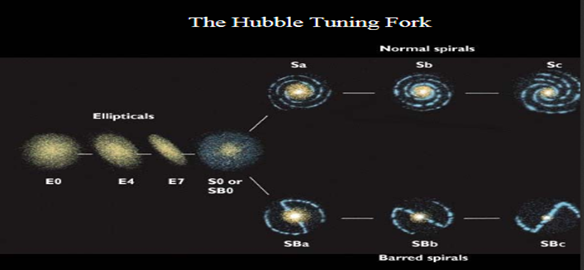

Tel qu’on le voit dans l’image ci-dessus, chaque type de galaxies possède une variété d’états ayant leurs propres caractéristiques. C’est principalement grâce à cette image que nous avons développé nos idées de primitives puisqu’elle ne se base pas sur des photos à haute résolution, mais plutôt sur des caractéristiques facilement discernables. Nous devions aussi prendre en compte les contraintes de temps afin de s’assurer que nous pouvions bien implémenter le tout. Notre première impression fut que le taux de pixels bleus capterait une grande majorité des galaxies spirales, à l’exception de l’elliptique S0 (qui s’avère être le cas le plus complexe à distinguer). Ensuite, nous avons opté pour la primitive initialement testée qui compare la quantité de pixels blancs sur les images binarisées; cette caractéristique est bien observable ci-haut lorsqu’on regarde l’aire importante couverte par les elliptiques. Finalement, notre dernière primitive se base sur nos observations personnelles des images fournies. Nous avons collectivement remarqué que dans la majorité des cas, les galaxies elliptiques étaient beaucoup plus rondes et également étendues, tandis que les spirales semblaient avoir une orientation définie. Cela dit, on a extrait le rectangle minimum englobant l’image binarisée afin de calculer un ratio en sa longueur et sa largeur; un ratio de 1 représenterait donc une circularité parfaite et un ratio plus près de 0 expliquerait un allongement de la galaxie, peu importe le sens.



#3.

Le nombre de pixels blancs dans notre images grayscale par rapport au nombre de pixels bleus présentes dans l'image permet de montrer une tendance pour les galaxies smooth et spiral.
Les galaxies spirales qui ont un grand nombre de pixels bleus ont tendance à avoir un faible nombre de pixels blancs dans l’image en teintes de gris binarisée.
De plus, les galaxies qui ont un nombre élevé de pixels blanches dans l’image en teintes de gris binarisée avec un petit nombre de pixels bleus ont tendance à être des galaxies smooth.
Dans l’image ci-dessous, on peut voir les galaxies spiral (en vert) et les smooth (en rouge) se regroupe de façon distincte. 



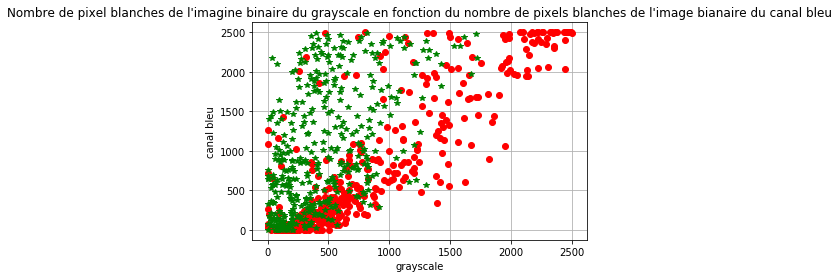

In [74]:
# Primitive utilisées :
# (L'énoncé demande de discuter seulement 2 primitives, alors les autres sont en commentaire)

#TracePlot(ExtractNumberOfBlackAndWhitePixels(X_train_binary), 'Nombre de pixels blanches en fonction du nombre de pixels noires dans les images binaire grayscale', 'Nombre de pixels blancs', 'Nombre de pixels noirs')
TracePlot(ExtractNbOfBluePixelsVersusWhitePixelsInGrayscale(X_train_binary, X_train_crop_blue_mid), "Nombre de pixel blanches de l'imagine binaire du grayscale en fonction du nombre de pixels blanches de l'image bianaire du canal bleu", "grayscale", "canal bleu")
#TracePlot(ExtractRatio(127, X_train_crop, Y_train), "Ratio Longeur / Largeur", "", "Ratio")

#4. 

Notre arbre de décision nous donne une précision de 89,40% sur les valeurs d'entraînement et une valeur de 82,50% pour les valeurs de test. C'est valeur sont à ce niveau car les primitives que nous avons sélectionnées sont suffisamment discriminantes pour permettrent de distinguer les différentes classes. Aussi, lorsqu'il y a plus de données, nos résultats s'améliorent, car notre algorithme d'apprentissage à plus d'information pour créer un modèle rigoureux. Nous avons utilisé 1200 données dont 70% étaient pour l’entrainement et 30% pour les tests.  Finalement, nous avons essayé plusieurs hyper-paramètres différents de max-depth et de min_samples_leaf afin d'optimiser notre score de précision avec nos données. Les meilleurs résultats sont obtenus avec un max_depth de 9 et un min_samples_leaf de 6.

Le bruit retrouvé dans les données d’entrainement peut diminuer la précision de notre arbre de décision. Puisque nous n’avons pas construit d’algorithme permettant de détecter les artéfacts et de les retirer, tout artéfact créant du bruit dans nos données seront pris en compte. Un grand nombre de données d’entrainement peut permettre de diminuer l’impact si les données avec du bruit ne sont pas en trop grand nombre.


Accuracy score for train values = 0.894048
Accuracy score for test values = 0.825000


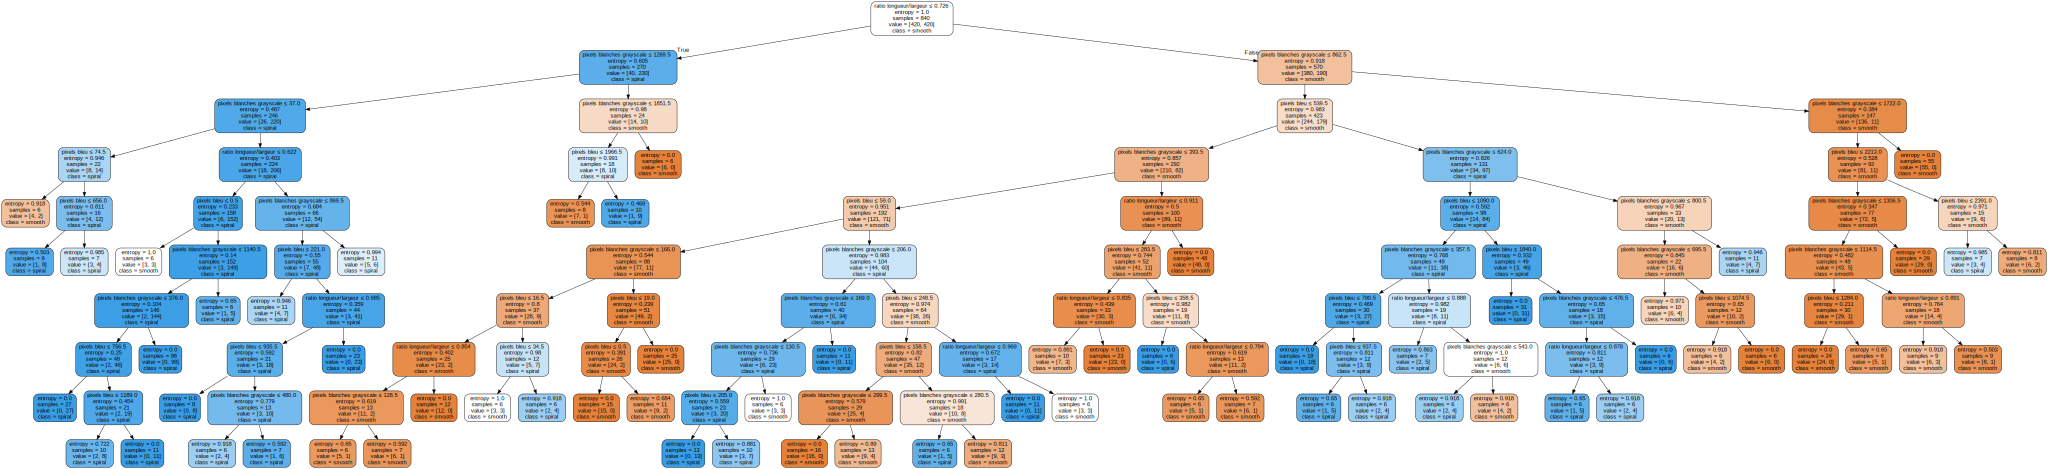

In [75]:
ShowAccScore(Y_train_tree, prediction_train, "train")
#ShowAccScore(Y_val_tree, prediction_val, "validation") # Les valeurs de validation ne sont plus utilisées
ShowAccScore(Y_test_tree, prediction_test, "test")
ExportTree()

#5. 

Bien entendu, nos primitives ne sont pas parfaites et il y a grandement place à amélioration. Une des nombreuses solutions possibles aurait été de comparer les histogrammes 2D de distribution d’intensité entre les différentes images. Les galaxies spirales présentent généralement une distribution ondulatoire, tandis que les elliptiques ressemblent plutôt à une courbe normale en termes d’intensité/luminosité. Aussi, la numérisation de profiles RGB complets aurait pu potentiellement être plus efficace que notre primitive qui vérifie uniquement la quantité de bleu dans l’image réduite.

#6. 

Étant donné l’ampleur du problème et la quantité importante d’approches possibles, nous croyons avoir bien performé en atteignant un seuil de classification supérieur à la classification aléatoire, soit un résultat de 84.6% de réussite. En utilisant des primitives telles que la surface blanche de l’image binarisée, le taux de pixels bleus (seuillé) de l’image ainsi que le ratio entre la largeur et la longueur de la surface binarisée, nous avons conçu un modèle d’arbre de décision satisfaisant. De multiples tests nous ont permis d’optimiser les hyperparamètres de notre arbre afin de maximiser nos résultats. Enfin, il est clair que nos primitives ne sont pas les plus précises; des analyses plus en détail des profiles d’image de chaque classe (spirale et elliptique) auraient probablement mieux performé que des données quantitatives plus basiques comme les comptes et les ratios. Somme toutes, nous avons rempli les objectifs de ce laboratoire et malgré que nous ayons pris beaucoup de temps à trouver nos primitives, le tout s’est bien déroulé.

Références :

1 https://www.astro.umd.edu/~richard/ASTRO620/Lecture15-sm.pdf

2 http://benanne.github.io/2014/04/05/galaxy-zoo.html

3 http://cs229.stanford.edu/proj2016/report/GauthierJainNoordeh-GalaxyMorphology-report.pdf 
